<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/drone_DAE_3_SSIM_loss_combined_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

압축 해제 완료: /content/ICSV31AIChallengeDataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모듈 불러오기

In [5]:
import csv
import argparse
import os
from typing import Any, List, Tuple

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 라벨링 및 데이터셋 로더
+ global scaling STFT 적용

In [6]:
#######################
# 1. Utils
#######################
def read_csv(file_path: str) -> List:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        return list(reader)

def save_csv(save_data: List[Any], save_file_path: str) -> None:
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator="\n")
        writer.writerows(save_data)

def get_anomaly_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    train_mode = file_name.split("_")[0]
    if train_mode == "test":
        return -1
    elif "normal" in file_name:
        return 0
    else:
        return 1

def get_drone_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    drone_mode = file_name.split("_")[1]
    if drone_mode == "A":
        return 0
    elif drone_mode == "B":
        return 1
    elif drone_mode == "C":
        return 2
    else:
        return -1

def get_direction_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    direction_mode = file_name.split("_")[2]
    if direction_mode == "Back":
        return 0
    elif direction_mode == "Front":
        return 1
    elif direction_mode == "Left":
        return 2
    elif direction_mode == "Right":
        return 3
    elif direction_mode == "Clockwise":
        return 4
    elif direction_mode == "CounterClockwise":
        return 5
    else:
        return -1

In [7]:
def get_train_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if get_anomaly_label(f) == 0]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=True
    )

    # num_workers가 0일 경우 prefetch_factor를 제거
    if num_workers > 0:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory,
                          persistent_workers=True, prefetch_factor=2)
    else:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)

def get_eval_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=False
    )
    if num_workers > 0:
        return DataLoader(dataset, batch_size=1, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory,
                          persistent_workers=True, prefetch_factor=2), file_list
    else:
        return DataLoader(dataset, batch_size=1, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory), file_list

In [8]:
#######################
# 2. Feature Extraction & Augmentation
#######################
# 계산된 전역 평균과 표준편차
GLOBAL_MEAN =  -6.191081653188225
GLOBAL_STD = 12.042716979980469

def wav_to_log_stft(
    wav_path: str,
    sr: int,
    n_fft: int,
    win_length: int,
    hop_length: int,
    power: float,
) -> torch.Tensor:
    """
    WAV 파일을 STFT 기반 로그 스펙트럼으로 변환.
    - torchaudio.transforms.Spectrogram로 STFT 계산
    - AmplitudeToDB로 로그 변환 후 global standard scaling 적용 **
    """
    stft_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )
    wav_data, _ = torchaudio.load(wav_path)
    spec = stft_transform(wav_data)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    log_spec = amp_to_db(spec)

    # 전체 데이터셋의 평균과 표준편차로 정규화 적용
    log_spec = (log_spec - GLOBAL_MEAN) / (GLOBAL_STD + 1e-9)
    return log_spec


def augment_spec(spec: torch.Tensor) -> torch.Tensor:
    max_shift = int(spec.shape[-1] * 0.1)
    shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
    spec = torch.roll(spec, shifts=shift, dims=-1)
    time_mask_param = max(1, int(spec.shape[-1] * 0.05))
    time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    spec = time_mask(spec)
    freq_mask_param = max(1, int(spec.shape[-2] * 0.05))
    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    spec = freq_mask(spec)
    return spec

#######################
# 3. Dataset
#######################
class BaselineDataLoader(Dataset):
    def __init__(
        self,
        file_list: List[str],
        sr: int,
        n_fft: int,
        win_length: int,
        hop_length: int,
        power: float,
        augment: bool = False
    ) -> None:
        self.file_list = file_list
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.power = power
        self.augment = augment

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int, int]:
        wav_path = self.file_list[idx]
        spec = wav_to_log_stft(wav_path, self.sr, self.n_fft, self.win_length, self.hop_length, self.power)
        if self.augment:
            spec = augment_spec(spec)
        anomaly_label = get_anomaly_label(wav_path)
        drone_label = get_drone_label(wav_path)
        direction_label = get_direction_label(wav_path)
        return spec, anomaly_label, drone_label, direction_label

from typing import Tuple, List
from torch.utils.data import DataLoader


def get_train_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if get_anomaly_label(f) == 0]
    dataset = BaselineDataLoader(file_list, sr=args.sr, n_fft=args.n_fft, win_length=args.win_length, hop_length=args.hop_length, power=args.power, augment=True)
    if num_workers > 0:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True, prefetch_factor=2)
    else:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

def get_eval_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list]
    dataset = BaselineDataLoader(file_list, sr=args.sr, n_fft=args.n_fft, win_length=args.win_length, hop_length=args.hop_length, power=args.power, augment=False)
    if num_workers > 0:
        return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True, prefetch_factor=2), file_list
    else:
        return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory), file_list

## 모델 학습 및 평가

In [7]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse, os
from tqdm import tqdm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
# pip install pytorch-msssim
from pytorch_msssim import ssim

#############################
# SSIM Loss Implementation
#############################
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, data_range=1.0, K=(0.01, 0.03)):
        """
        SSIMLoss는 pytorch_msssim의 ssim 함수를 이용하여,
        두 이미지 간의 구조적 유사성을 평가합니다.
        """
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.data_range = data_range
        self.K = K

    def forward(self, img1, img2):
        # ssim 값은 1에 가까울수록 유사하므로, loss는 1 - ssim으로 정의
        return 1 - ssim(img1, img2, data_range=self.data_range, win_size=self.window_size, size_average=self.size_average, K=self.K)

#############################
# Combined Loss (SSIM + L1)
#############################
class CombinedLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, ssim_weight=0.8, l1_weight=0.2):
        """
        SSIM과 L1 손실을 결합합니다.
          - window_size: SSIM 계산 시 윈도우 크기
          - size_average: 손실 산출 시 평균 사용 여부
          - ssim_weight: SSIM 손실의 가중치
          - l1_weight: L1 손실의 가중치
        """
        super(CombinedLoss, self).__init__()
        self.ssim_loss = SSIMLoss(window_size, size_average)
        self.ssim_weight = ssim_weight
        self.l1_weight = l1_weight

    def forward(self, img1, img2):
        loss_ssim = self.ssim_loss(img1, img2)
        loss_l1 = F.l1_loss(img1, img2)
        return self.ssim_weight * loss_ssim + self.l1_weight * loss_l1

#############################
# Utility: 크기 맞춤 함수
#############################
def match_size(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    src_h, src_w = source.size(2), source.size(3)
    tgt_h, tgt_w = target.size(2), target.size(3)
    if src_h > tgt_h or src_w > tgt_w:
        start_h = (src_h - tgt_h) // 2
        start_w = (src_w - tgt_w) // 2
        source = source[:, :, start_h:start_h+tgt_h, start_w:start_w+tgt_w]
    elif src_h < tgt_h or src_w < tgt_w:
        diff_h = tgt_h - src_h
        diff_w = tgt_w - src_w
        source = F.pad(source, (diff_w // 2, diff_w - diff_w // 2,
                                diff_h // 2, diff_h - diff_h // 2))
    return source

#############################
# Model Architecture (DAE)
#############################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.03):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)

    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock(x)
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.03):
        super(DenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

    def forward(self, x):
        e1 = self.enc1(x)   # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        d5 = self.dec5(e5, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def DAEModel(dropout) -> nn.Module:
    return DenoisingAutoencoder(input_channels=1, dropout=dropout)

#############################
# Train & Evaluate 관련 함수들
#############################
def get_args() -> argparse.Namespace:
    param = {
        "train_dir": "/content/ICSV31AIChallengeDataset/train",
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_dae_combined.pth",
        "epochs": 200,
        "batch_size": 32,
        "lr": 0.001,
        "gpu": 0,
        "n_workers": 1,
        "early_stopping_patience": 10,
        "noise_factor": 0.2,
        "dropout": 0.05,
        # 누락된 속성 추가
        "sr": 16000,  # 샘플링 레이트
        "n_fft": 2048, # FFT 크기
        "win_length": 512, # 윈도우 길이
        "hop_length": 256, # 홉 길이
        "power": 2.0 # STFT 계산에 사용할 power 값
    }
    parser = argparse.ArgumentParser()
    for key, value in param.items():
        parser.add_argument(f"--{key.replace('_','-')}", default=value, type=type(value))
    args, unknown = parser.parse_known_args()
    return args

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_and_evaluate(args: argparse.Namespace) -> None:
    print("Training started...")
    os.makedirs(args.result_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    set_seed(2025)

    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True

    model = DAEModel(args.dropout).to(device)

    try:
        from torchsummary import summary
        summary(model, input_size=(1, 256, 256))
    except ImportError:
        print(model)

    train_loader = get_train_loader(args, pin_memory=True, num_workers=args.n_workers)
    # 평가 시 파일명을 활용하기 위해 file_list도 함께 반환
    val_loader, eval_file_list = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    criterion = CombinedLoss(window_size=11, size_average=True, ssim_weight=0.8, l1_weight=0.2)

    train_losses = []
    val_losses = []
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, args.epochs + 1):
        model.train()
        total_loss = 0.0
        count = 0
        p_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{args.epochs}", ncols=100)
        for data in p_bar:
            spec = data[0].to(device)
            noisy_spec = spec + args.noise_factor * torch.randn_like(spec)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                decoded = model(noisy_spec)
                loss = criterion(decoded, spec)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            count += 1
            p_bar.set_description(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        avg_train_loss = total_loss / count
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch} average train loss: {avg_train_loss:.4f}")

        model.eval()
        total_val_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for val_data in val_loader:
                spec, anomaly_label, _, _ = val_data
                spec = spec.to(device)
                decoded = model(spec)
                loss = criterion(decoded, spec)
                total_val_loss += loss.item()
                val_count += 1
        avg_val_loss = total_val_loss / val_count
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch} average val loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            checkpoint_path = os.path.join(args.model_dir, args.model_path)
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Epoch {epoch}: Model improved. Saved checkpoint to {checkpoint_path}")
        else:
            patience_counter += 1
            if patience_counter >= args.early_stopping_patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    # 학습 곡선 그리기 및 저장
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Combined Loss (SSIM + L1)')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    curve_path = os.path.join(args.result_dir, "learning_curve.png")
    plt.savefig(curve_path)
    plt.show()
    print(f"Learning curve saved to {curve_path}")

    # 최종 평가: 전체 validation set에 대한 평가 (PR AUC 기반)
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            spec, anomaly_label, _, _ = val_data
            spec = spec.to(device)
            decoded = model(spec)
            loss = criterion(decoded, spec)
            y_pred.append(loss.item())
            y_true.append(anomaly_label.item() if anomaly_label.dim() == 0 else anomaly_label.cpu().numpy()[0])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    pr_auc = metrics.average_precision_score(y_true, y_pred)
    print(f"Evaluation PR AUC: {pr_auc:.4f}")

    # CSV 파일 저장: 각 파일별 score와 드론 레이블 등 저장
    score_list = [["File", "Score"]]
    drone_label_list = []
    y_true_csv, y_pred_csv = [], []
    # val_loader의 배치 사이즈가 1이라고 가정하여, eval_file_list와 인덱스가 일치함.
    with torch.no_grad():
        for idx, (spec, anomaly_label, drone_label, _) in enumerate(val_loader):
            spec = spec.to(device)
            decoded = model(spec)
            loss = criterion(decoded, spec)
            drone_val = drone_label.item() if drone_label.dim() == 0 else drone_label.cpu().numpy()[0]
            drone_label_list.append(drone_val)
            y_true_csv.append(1 if anomaly_label.item() > 0 else 0)
            y_pred_csv.append(loss.item())
            file_name = os.path.splitext(os.path.basename(eval_file_list[idx]))[0]
            score_list.append([file_name, loss.item()])

    pr_auc_csv = metrics.average_precision_score(y_true_csv, y_pred_csv)
    print("Evaluation PR AUC (CSV):", pr_auc_csv)

    # CSV 저장 (csv 모듈 사용)
    import csv
    csv_path = os.path.join(args.result_dir, "eval_score.csv")
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(score_list)
    print(f"Saved evaluation scores to {csv_path}")

    # 드론 타입별 PR AUC 계산 (예: drone type "A", "B", "C")
    drone_type_list = ["A", "B", "C"]
    for drone_type in drone_type_list:
        indices = [i for i, label in enumerate(drone_label_list) if label == drone_type_list.index(drone_type)]
        pred_labels = [y_pred_csv[i] for i in indices]
        true_labels = [y_true_csv[i] for i in indices]
        if len(true_labels) > 0:
            pr_auc_drone = metrics.average_precision_score(true_labels, pred_labels)
            print(f"Drone type {drone_type} PR AUC: {pr_auc_drone:.4f}")
        else:
            print(f"Drone type {drone_type}: no samples")

Training started...
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              64
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]             320
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
           Dropout-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,248
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
    ResidualBlock-10         [-1, 32, 128, 128]               0
     EncoderBlock-11         [-1, 32, 128, 128]               0
           Conv2d-12           [-1, 64, 64, 64]           2,112
      BatchNorm2d-13           [-1, 64, 64, 64]             128


<ipython-input-9-1875d648599c>:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/200:   0%|                                                          | 0/169 [00:00<?, ?it/s]<ipython-input-9-1875d648599c>:246: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1, Loss: 0.5609: 100%|██████████████████████████████████████| 169/169 [01:01<00:00,  2.77it/s]

Epoch 1 average train loss: 0.6718


Epoch 1 average val loss: 0.5104
Epoch 1: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 2, Loss: 0.4915: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.28it/s]


Epoch 2 average train loss: 0.4746
Epoch 2 average val loss: 0.4304
Epoch 2: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 3, Loss: 0.4100: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.29it/s]


Epoch 3 average train loss: 0.4095
Epoch 3 average val loss: 0.3948
Epoch 3: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 4, Loss: 0.4731: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.29it/s]


Epoch 4 average train loss: 0.3751
Epoch 4 average val loss: 0.3513
Epoch 4: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 5, Loss: 0.3326: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.30it/s]


Epoch 5 average train loss: 0.3578
Epoch 5 average val loss: 0.3200
Epoch 5: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 6, Loss: 0.3507: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.29it/s]


Epoch 6 average train loss: 0.3407
Epoch 6 average val loss: 0.2765
Epoch 6: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 7, Loss: 0.3088: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.30it/s]


Epoch 7 average train loss: 0.3321
Epoch 7 average val loss: 0.2752
Epoch 7: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 8, Loss: 0.3492: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.29it/s]


Epoch 8 average train loss: 0.3302
Epoch 8 average val loss: 0.2867


Epoch 9, Loss: 0.3322: 100%|██████████████████████████████████████| 169/169 [00:51<00:00,  3.30it/s]


Epoch 9 average train loss: 0.3162
Epoch 9 average val loss: 0.2699
Epoch 9: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 10, Loss: 0.2975: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.31it/s]


Epoch 10 average train loss: 0.3057
Epoch 10 average val loss: 0.2592
Epoch 10: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 11, Loss: 0.3149: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.32it/s]


Epoch 11 average train loss: 0.2996
Epoch 11 average val loss: 0.2673


Epoch 12, Loss: 0.3305: 100%|█████████████████████████████████████| 169/169 [00:51<00:00,  3.31it/s]


Epoch 12 average train loss: 0.2968
Epoch 12 average val loss: 0.2720


Epoch 13, Loss: 0.2781: 100%|█████████████████████████████████████| 169/169 [00:51<00:00,  3.31it/s]


Epoch 13 average train loss: 0.2917
Epoch 13 average val loss: 0.2496
Epoch 13: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 14, Loss: 0.2809: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 14 average train loss: 0.2791
Epoch 14 average val loss: 0.2336
Epoch 14: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 15, Loss: 0.2810: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 15 average train loss: 0.2819
Epoch 15 average val loss: 0.2356


Epoch 16, Loss: 0.2622: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 16 average train loss: 0.2791
Epoch 16 average val loss: 0.2424


Epoch 17, Loss: 0.2878: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 17 average train loss: 0.2753
Epoch 17 average val loss: 0.2317
Epoch 17: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 18, Loss: 0.2821: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 18 average train loss: 0.2669
Epoch 18 average val loss: 0.2391


Epoch 19, Loss: 0.2505: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 19 average train loss: 0.2610
Epoch 19 average val loss: 0.2131
Epoch 19: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 20, Loss: 0.2730: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 20 average train loss: 0.2560
Epoch 20 average val loss: 0.2254


Epoch 21, Loss: 0.2453: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 21 average train loss: 0.2587
Epoch 21 average val loss: 0.2414


Epoch 22, Loss: 0.2521: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.32it/s]


Epoch 22 average train loss: 0.2530
Epoch 22 average val loss: 0.2251


Epoch 23, Loss: 0.3044: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 23 average train loss: 0.2526
Epoch 23 average val loss: 0.2085
Epoch 23: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 24, Loss: 0.2401: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.35it/s]


Epoch 24 average train loss: 0.2479
Epoch 24 average val loss: 0.2057
Epoch 24: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 25, Loss: 0.3070: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 25 average train loss: 0.2518
Epoch 25 average val loss: 0.2335


Epoch 26, Loss: 0.2211: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.35it/s]


Epoch 26 average train loss: 0.2466
Epoch 26 average val loss: 0.2127


Epoch 27, Loss: 0.3146: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.35it/s]


Epoch 27 average train loss: 0.2470
Epoch 27 average val loss: 0.2246


Epoch 28, Loss: 0.2751: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 28 average train loss: 0.2547
Epoch 28 average val loss: 0.2271


Epoch 29, Loss: 0.2552: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.36it/s]


Epoch 29 average train loss: 0.2407
Epoch 29 average val loss: 0.2068


Epoch 30, Loss: 0.2350: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.36it/s]


Epoch 30 average train loss: 0.2385
Epoch 30 average val loss: 0.2025
Epoch 30: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 31, Loss: 0.2013: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.35it/s]


Epoch 31 average train loss: 0.2323
Epoch 31 average val loss: 0.1971
Epoch 31: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 32, Loss: 0.2329: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 32 average train loss: 0.2332
Epoch 32 average val loss: 0.1991


Epoch 33, Loss: 0.2348: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.36it/s]


Epoch 33 average train loss: 0.2343
Epoch 33 average val loss: 0.2015


Epoch 34, Loss: 0.2630: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.36it/s]


Epoch 34 average train loss: 0.2313
Epoch 34 average val loss: 0.2010


Epoch 35, Loss: 0.1977: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 35 average train loss: 0.2467
Epoch 35 average val loss: 0.2015


Epoch 36, Loss: 0.2279: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 36 average train loss: 0.2291
Epoch 36 average val loss: 0.1961
Epoch 36: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 37, Loss: 0.2152: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 37 average train loss: 0.2239
Epoch 37 average val loss: 0.1971


Epoch 38, Loss: 0.2117: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 38 average train loss: 0.2242
Epoch 38 average val loss: 0.1863
Epoch 38: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 39, Loss: 0.2332: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 39 average train loss: 0.2229
Epoch 39 average val loss: 0.1884


Epoch 40, Loss: 0.2115: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 40 average train loss: 0.2144
Epoch 40 average val loss: 0.1885


Epoch 41, Loss: 0.1984: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 41 average train loss: 0.2175
Epoch 41 average val loss: 0.1826
Epoch 41: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 42, Loss: 0.3035: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 42 average train loss: 0.2178
Epoch 42 average val loss: 0.2294


Epoch 43, Loss: 0.2467: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.33it/s]


Epoch 43 average train loss: 0.2229
Epoch 43 average val loss: 0.2026


Epoch 44, Loss: 0.2488: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 44 average train loss: 0.2130
Epoch 44 average val loss: 0.1884


Epoch 45, Loss: 0.2290: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 45 average train loss: 0.2170
Epoch 45 average val loss: 0.1880


Epoch 46, Loss: 0.2002: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.35it/s]


Epoch 46 average train loss: 0.2119
Epoch 46 average val loss: 0.1812
Epoch 46: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 47, Loss: 0.2092: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 47 average train loss: 0.2126
Epoch 47 average val loss: 0.1835


Epoch 48, Loss: 0.1900: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.36it/s]


Epoch 48 average train loss: 0.2134
Epoch 48 average val loss: 0.1840


Epoch 49, Loss: 0.1877: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.34it/s]


Epoch 49 average train loss: 0.2099
Epoch 49 average val loss: 0.1833


Epoch 50, Loss: 0.1901: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.36it/s]


Epoch 50 average train loss: 0.2054
Epoch 50 average val loss: 0.1867


Epoch 51, Loss: 0.1765: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.35it/s]


Epoch 51 average train loss: 0.2005
Epoch 51 average val loss: 0.1818


Epoch 52, Loss: 0.3039: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 52 average train loss: 0.2049
Epoch 52 average val loss: 0.1952


Epoch 53, Loss: 0.2115: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 53 average train loss: 0.2102
Epoch 53 average val loss: 0.1774
Epoch 53: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 54, Loss: 0.2181: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 54 average train loss: 0.2038
Epoch 54 average val loss: 0.1778


Epoch 55, Loss: 0.1908: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 55 average train loss: 0.2050
Epoch 55 average val loss: 0.1784


Epoch 56, Loss: 0.1819: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 56 average train loss: 0.1965
Epoch 56 average val loss: 0.1783


Epoch 57, Loss: 0.1841: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 57 average train loss: 0.2027
Epoch 57 average val loss: 0.1720
Epoch 57: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 58, Loss: 0.1980: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.38it/s]


Epoch 58 average train loss: 0.2023
Epoch 58 average val loss: 0.1784


Epoch 59, Loss: 0.2795: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 59 average train loss: 0.1972
Epoch 59 average val loss: 0.1836


Epoch 60, Loss: 0.1824: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.38it/s]


Epoch 60 average train loss: 0.1973
Epoch 60 average val loss: 0.1714
Epoch 60: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 61, Loss: 0.1944: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 61 average train loss: 0.1990
Epoch 61 average val loss: 0.1907


Epoch 62, Loss: 0.1966: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.38it/s]


Epoch 62 average train loss: 0.1942
Epoch 62 average val loss: 0.1693
Epoch 62: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 63, Loss: 0.2175: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 63 average train loss: 0.1980
Epoch 63 average val loss: 0.1675
Epoch 63: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 64, Loss: 0.1871: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 64 average train loss: 0.2016
Epoch 64 average val loss: 0.1797


Epoch 65, Loss: 0.1966: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 65 average train loss: 0.1998
Epoch 65 average val loss: 0.1672
Epoch 65: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 66, Loss: 0.1948: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 66 average train loss: 0.1990
Epoch 66 average val loss: 0.1656
Epoch 66: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 67, Loss: 0.1615: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 67 average train loss: 0.1962
Epoch 67 average val loss: 0.1747


Epoch 68, Loss: 0.2314: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 68 average train loss: 0.1960
Epoch 68 average val loss: 0.1631
Epoch 68: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 69, Loss: 0.2659: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 69 average train loss: 0.1990
Epoch 69 average val loss: 0.1989


Epoch 70, Loss: 0.1728: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 70 average train loss: 0.1963
Epoch 70 average val loss: 0.1694


Epoch 71, Loss: 0.2346: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 71 average train loss: 0.1912
Epoch 71 average val loss: 0.1657


Epoch 72, Loss: 0.1796: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 72 average train loss: 0.1906
Epoch 72 average val loss: 0.1657


Epoch 73, Loss: 0.1649: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 73 average train loss: 0.1896
Epoch 73 average val loss: 0.1737


Epoch 74, Loss: 0.1808: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 74 average train loss: 0.1924
Epoch 74 average val loss: 0.1663


Epoch 75, Loss: 0.1661: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 75 average train loss: 0.1910
Epoch 75 average val loss: 0.1679


Epoch 76, Loss: 0.2365: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 76 average train loss: 0.1843
Epoch 76 average val loss: 0.1705


Epoch 77, Loss: 0.1896: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 77 average train loss: 0.1871
Epoch 77 average val loss: 0.1600
Epoch 77: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 78, Loss: 0.2131: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 78 average train loss: 0.1852
Epoch 78 average val loss: 0.1720


Epoch 79, Loss: 0.2164: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 79 average train loss: 0.1909
Epoch 79 average val loss: 0.1717


Epoch 80, Loss: 0.1659: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 80 average train loss: 0.1890
Epoch 80 average val loss: 0.1606


Epoch 81, Loss: 0.2649: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 81 average train loss: 0.1824
Epoch 81 average val loss: 0.1563
Epoch 81: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 82, Loss: 0.1738: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 82 average train loss: 0.1853
Epoch 82 average val loss: 0.1580


Epoch 83, Loss: 0.1747: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 83 average train loss: 0.1877
Epoch 83 average val loss: 0.1632


Epoch 84, Loss: 0.1607: 100%|█████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 84 average train loss: 0.1805
Epoch 84 average val loss: 0.1607


Epoch 85, Loss: 0.1707: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 85 average train loss: 0.1790
Epoch 85 average val loss: 0.1531
Epoch 85: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 86, Loss: 0.1692: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 86 average train loss: 0.1845
Epoch 86 average val loss: 0.1651


Epoch 87, Loss: 0.1773: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 87 average train loss: 0.1860
Epoch 87 average val loss: 0.1587


Epoch 88, Loss: 0.1603: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 88 average train loss: 0.1863
Epoch 88 average val loss: 0.1588


Epoch 89, Loss: 0.2349: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 89 average train loss: 0.1833
Epoch 89 average val loss: 0.1666


Epoch 90, Loss: 0.1664: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 90 average train loss: 0.1820
Epoch 90 average val loss: 0.1536


Epoch 91, Loss: 0.1586: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 91 average train loss: 0.1839
Epoch 91 average val loss: 0.1539


Epoch 92, Loss: 0.1872: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 92 average train loss: 0.1854
Epoch 92 average val loss: 0.1906


Epoch 93, Loss: 0.1635: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 93 average train loss: 0.1803
Epoch 93 average val loss: 0.1593


Epoch 94, Loss: 0.1654: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 94 average train loss: 0.1699
Epoch 94 average val loss: 0.1557


Epoch 95, Loss: 0.2054: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 95 average train loss: 0.1688
Epoch 95 average val loss: 0.1527
Epoch 95: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 96, Loss: 0.1603: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 96 average train loss: 0.1677
Epoch 96 average val loss: 0.1597


Epoch 97, Loss: 0.1543: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 97 average train loss: 0.1639
Epoch 97 average val loss: 0.1567


Epoch 98, Loss: 0.1611: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.40it/s]


Epoch 98 average train loss: 0.1612
Epoch 98 average val loss: 0.1558


Epoch 99, Loss: 0.1579: 100%|█████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 99 average train loss: 0.1616
Epoch 99 average val loss: 0.1474
Epoch 99: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 100, Loss: 0.1661: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 100 average train loss: 0.1613
Epoch 100 average val loss: 0.1528


Epoch 101, Loss: 0.1583: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 101 average train loss: 0.1581
Epoch 101 average val loss: 0.1531


Epoch 102, Loss: 0.1651: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 102 average train loss: 0.1673
Epoch 102 average val loss: 0.1687


Epoch 103, Loss: 0.1566: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 103 average train loss: 0.1604
Epoch 103 average val loss: 0.1517


Epoch 104, Loss: 0.1583: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 104 average train loss: 0.1565
Epoch 104 average val loss: 0.1510


Epoch 105, Loss: 0.1577: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 105 average train loss: 0.1586
Epoch 105 average val loss: 0.1531


Epoch 106, Loss: 0.1667: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 106 average train loss: 0.1686
Epoch 106 average val loss: 0.1703


Epoch 107, Loss: 0.1555: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 107 average train loss: 0.1620
Epoch 107 average val loss: 0.1558


Epoch 108, Loss: 0.1529: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.39it/s]


Epoch 108 average train loss: 0.1558
Epoch 108 average val loss: 0.1463
Epoch 108: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined.pth


Epoch 109, Loss: 0.1642: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 109 average train loss: 0.1684
Epoch 109 average val loss: 0.1662


Epoch 110, Loss: 0.1524: 100%|████████████████████████████████████| 169/169 [00:49<00:00,  3.38it/s]


Epoch 110 average train loss: 0.1611
Epoch 110 average val loss: 0.1483


Epoch 111, Loss: 0.1541: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 111 average train loss: 0.1561
Epoch 111 average val loss: 0.1499


Epoch 112, Loss: 0.1454: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 112 average train loss: 0.1534
Epoch 112 average val loss: 0.1470


Epoch 113, Loss: 0.1475: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 113 average train loss: 0.1538
Epoch 113 average val loss: 0.1485


Epoch 114, Loss: 0.1553: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 114 average train loss: 0.1524
Epoch 114 average val loss: 0.1470


Epoch 115, Loss: 0.1512: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 115 average train loss: 0.1514
Epoch 115 average val loss: 0.1468


Epoch 116, Loss: 0.1478: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 116 average train loss: 0.1526
Epoch 116 average val loss: 0.1491


Epoch 117, Loss: 0.1537: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 117 average train loss: 0.1520
Epoch 117 average val loss: 0.1463


Epoch 118, Loss: 0.1517: 100%|████████████████████████████████████| 169/169 [00:50<00:00,  3.37it/s]


Epoch 118 average train loss: 0.1508
Epoch 118 average val loss: 0.1469
Early stopping triggered.


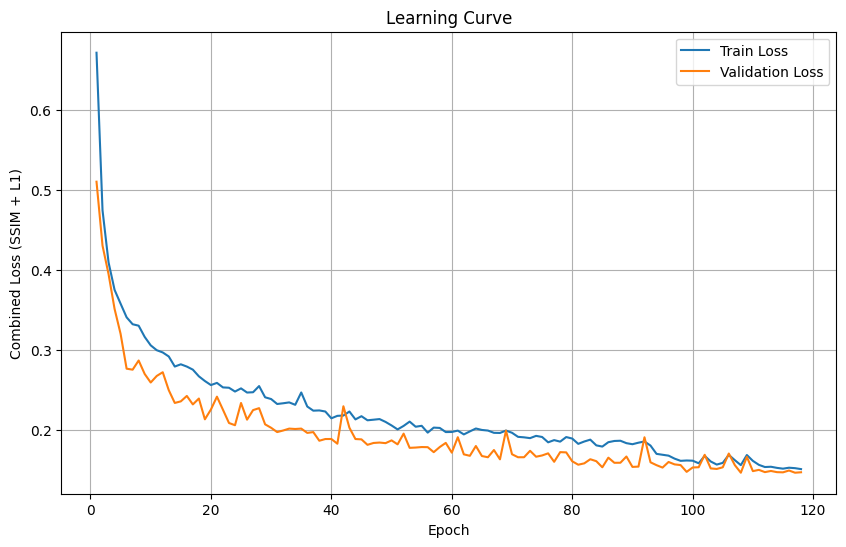

Learning curve saved to /content/drive/MyDrive/learning_curve.png
Evaluation PR AUC: 0.8382
Evaluation PR AUC (CSV): 0.8381500607383785
Saved evaluation scores to /content/drive/MyDrive/eval_score.csv
Drone type A PR AUC: 0.8448
Drone type B PR AUC: 0.8575
Drone type C PR AUC: 0.8563


In [10]:
 if __name__ == "__main__":
    args = get_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    set_seed(2025)
    train_and_evaluate(args)

## 평가 데이터 바꿔서 모델 가중치 불러오기

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix, roc_curve
import torchaudio
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "path"

# 모델 생성 및 가중치 불러오기
dropout = 0.05  # args 없이 직접 설정
model = DAEModel(dropout=dropout).to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_b0319.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=False)
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=256, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

#######################
# 평가 지표 계산
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")
